In [27]:
import pandas as pd 
import re
import nltk 
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

#train models 
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
import seaborn as sn
import matplotlib.pyplot as plt

# Get the data

In [28]:
train = pd.read_csv('../data/train.csv')
test = pd.read_csv('../data/test.csv')

# Studying data

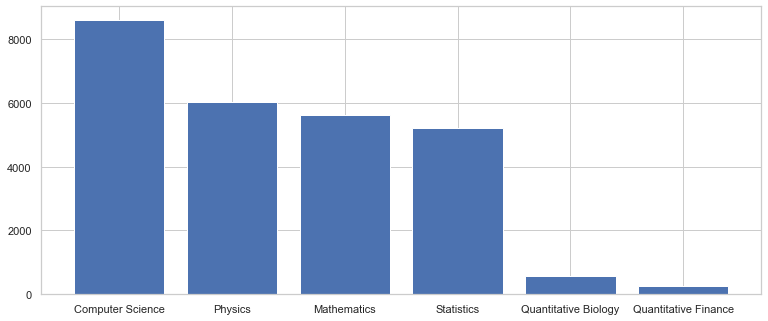

In [37]:
# What is the most common category 
cols = train.columns.tolist() 
cols = cols[3:]

train_sum = train[cols].sum() 
fig = plt.figure(figsize=(10, 4))
ax = fig.add_axes([0,0,1,1])
ax.bar(cols, train_sum)
plt.show()

## Correlation matrix


<AxesSubplot:>

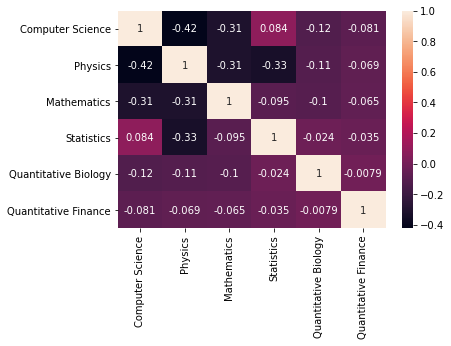

In [9]:
sn.heatmap(train[cols].corr(), annot=True)

# Cleaning data

## Preprocessing words

In [11]:
def normalize(text): 
    corpus = []
    ps = PorterStemmer()
    # get review and remove non alpha chars
    article = re.sub('[^a-zA-Z]', ' ', text)
    # to lower-case and tokenize
    article = article.lower().split()
    # stemming and stop word removal
    article = ' '.join([ps.stem(w) for w in article if not w in set(stopwords.words('english'))])
    corpus.append(article)
    return corpus

corpus = train['ABSTRACT'].apply(normalize)
print(corpus)


Exception ignored in: <function SeekableUnicodeStreamReader.__del__ at 0x000001C528B39CA0>
Traceback (most recent call last):
  File "C:\Users\julia\anaconda3\lib\site-packages\nltk\data.py", line 1162, in __del__
    self.close()
  File "C:\Users\julia\anaconda3\lib\site-packages\nltk\data.py", line 1191, in close
    self.stream.close()
KeyboardInterrupt: 


KeyboardInterrupt: 

In [ ]:
def normalize(df): 
    corpus = []
    ps = PorterStemmer()
    df_size = len(df) 
    for i in range(0,df_size):
        # get review and remove non alpha chars
        article = re.sub('[^a-zA-Z]', ' ', df['ABSTRACT'][i])
        # to lower-case and tokenize
        article = article.lower().split()
        # stemming and stop word removal
        article = ' '.join([ps.stem(w) for w in article if not w in set(stopwords.words('english'))])
        corpus.append(article)
    return corpus

# To avoid making this cleaning every time, we save teh output as a csv
def save_csv(corpus_train, file_name): 
    df = pd.DataFrame({'text': corpus_train})
    df.to_csv(file_name) 
    
    
#corpus_train = normalize(train)
#save_csv(corpus_train, 'preprocessed_train.csv')

#corpus_test = normalize(test)
#save_csv(corpus_test, 'preprocessed_test.csv')


# Split input and output

In [25]:
def get_input(preprocessed, x_col_name): 
    vectorizer = CountVectorizer(max_features = 1500)

    X_array = preprocessed.loc[:,x_col_name]
    X = vectorizer.fit_transform(X_array).toarray()
    return X

def get_outputs(df, y_cols_name):
    y = []
    for col_name in y_cols_name: 
        col_values = df.loc[:,col_name].values
        y.append(col_values)
    return y


preprocessed = pd.read_csv('preprocessed_train.csv')
preprocessed_submission = pd.read_csv('preprocessed_test.csv')
y_columns = train.columns[3:]
X = get_input(preprocessed, 'text')
y = get_outputs(train, y_columns)
X_submission = get_input(preprocessed_submission, 'text')

# Split train and test sets

In [22]:
y_train_test = []
for i in range(len(y_columns)): 
    X_train, X_test, y_train, y_test = train_test_split(X, y[i], test_size = 0.20, random_state = 0)
    y_train_test.append([y_train, y_test])

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(16777, 1500) (16777,)
(4195, 1500) (4195,)


# Train the model and generate results

In [23]:
def print_statistics(y_test, y_pred, column_name): 
    print(confusion_matrix(y_test, y_pred))
    print('Accuracy: ', accuracy_score(y_test, y_pred))
    print('Precision: ', precision_score(y_test, y_pred))
    print('Recall: ', recall_score(y_test, y_pred))
    print('F1: ', f1_score(y_test, y_pred))

In [24]:


classifier = GaussianNB()
gaussian_df = pd.DataFrame()
gaussian_submission_df = pd.DataFrame() 

for i in range(len(y_columns)): 
    col_name = y_columns[i]
    print("COL:", col_name)
    y_train = y_train_test[i][0]
    y_test = y_train_test[i][1]
    
    classifier.fit(X_train, y_train)
    gaussian_df[col_name]= classifier.predict(X_test)
    gaussian_submission_df[col_name] = classifier.predict(X_submission)
    print_statistics(y_test, gaussian_df[col_name].values, col_name)
    print()

index_submission= test.loc[:, 'ID'].values
print(len(gaussian_submission_df))
gaussian_submission_df = gaussian_submission_df.set_index(pd.Index(index_submission), 'ID')
gaussian_df.index.name = "ID"    
print(gaussian_submission_df)
gaussian_df.to_csv("submission_gaussian.csv")

COL: Computer Science
[[1600  851]
 [ 142 1602]]
Accuracy:  0.7632896305125149
Precision:  0.6530778638401957
Recall:  0.9185779816513762
F1:  0.7634024303073624

COL: Physics
[[2757  242]
 [ 182 1014]]
Accuracy:  0.8989272943980929
Precision:  0.8073248407643312
Recall:  0.8478260869565217
F1:  0.8270799347471451

COL: Mathematics
[[2394  726]
 [ 113  962]]
Accuracy:  0.8
Precision:  0.5699052132701422
Recall:  0.8948837209302326
F1:  0.6963445530220775

COL: Statistics
[[1770 1399]
 [  80  946]]
Accuracy:  0.6474374255065555
Precision:  0.40341151385927504
Recall:  0.9220272904483431
F1:  0.5612577870068228

COL: Quantitative Biology
[[2521 1558]
 [  30   86]]
Accuracy:  0.6214541120381406
Precision:  0.052311435523114354
Recall:  0.7413793103448276
F1:  0.09772727272727273

COL: Quantitative Finance
[[3733  412]
 [  28   22]]
Accuracy:  0.8951132300357568
Precision:  0.05069124423963134
Recall:  0.44
F1:  0.09090909090909091

8989
       Computer Science  Physics  Mathematics  Stati

In [50]:
# SVM

from sklearn.svm import SVC

classifier = SVC()
classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)

print(confusion_matrix(y_test, y_pred))
print('Accuracy: ', accuracy_score(y_test, y_pred))
print('Precision: ', precision_score(y_test, y_pred))
print('Recall: ', recall_score(y_test, y_pred))
print('F1: ', f1_score(y_test, y_pred))

[[4143    2]
 [  43    7]]
Accuracy:  0.9892729439809297
Precision:  0.7777777777777778
Recall:  0.14
F1:  0.23728813559322035


In [51]:
# Logistic Regression

from sklearn.linear_model import LogisticRegression

classifier = LogisticRegression()
classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)

print(confusion_matrix(y_test, y_pred))
print('Accuracy: ', accuracy_score(y_test, y_pred))
print('Precision: ', precision_score(y_test, y_pred))
print('Recall: ', recall_score(y_test, y_pred))
print('F1: ', f1_score(y_test, y_pred))

[[4130   15]
 [  29   21]]
Accuracy:  0.9895113230035757
Precision:  0.5833333333333334
Recall:  0.42
F1:  0.4883720930232558


In [52]:
# Perceptron

from sklearn.linear_model import Perceptron

classifier = Perceptron()
classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)

print(confusion_matrix(y_test, y_pred))
print('Accuracy: ', accuracy_score(y_test, y_pred))
print('Precision: ', precision_score(y_test, y_pred))
print('Recall: ', recall_score(y_test, y_pred))
print('F1: ', f1_score(y_test, y_pred))

[[4125   20]
 [  30   20]]
Accuracy:  0.9880810488676997
Precision:  0.5
Recall:  0.4
F1:  0.4444444444444445


In [53]:
# Decision Tree

from sklearn.tree import DecisionTreeClassifier

classifier = DecisionTreeClassifier()
classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)

print(confusion_matrix(y_test, y_pred))
print('Accuracy: ', accuracy_score(y_test, y_pred))
print('Precision: ', precision_score(y_test, y_pred))
print('Recall: ', recall_score(y_test, y_pred))
print('F1: ', f1_score(y_test, y_pred))

[[4120   25]
 [  33   17]]
Accuracy:  0.9861740166865316
Precision:  0.40476190476190477
Recall:  0.34
F1:  0.36956521739130443


In [55]:
# Random Forest

from sklearn.ensemble import RandomForestClassifier

classifier = RandomForestClassifier()
classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)

print(confusion_matrix(y_test, y_pred))
print('Accuracy: ', accuracy_score(y_test, y_pred))
print('Precision: ', precision_score(y_test, y_pred))
print('Recall: ', recall_score(y_test, y_pred))
print('F1: ', f1_score(y_test, y_pred))

[[4144    1]
 [  49    1]]
Accuracy:  0.9880810488676997
Precision:  0.5
Recall:  0.02
F1:  0.038461538461538464
[0 0 0 ... 0 0 0]
